# P2. Generación del Dataset
Una vez etiquetada las imágenes manualmente con el software VGG Image Annotator (VIA) 

Realizamos el procesamiento de todas las etiquetas de cada imagen almacenadas en los archivos .json exportados de VIA.

Para ello construiremos un Dataframe donde figuren los siguientes elementos:

- Nombre del Archivo
- Ruta del Archivo
- Objeto Detectado
- Segmentación del Objeto [Secuencia de Puntos que conforman el contorno del objeto]


In [33]:
import pandas as pd
import numpy as np
import cv2
import json
import random
import matplotlib.pyplot as plt
from glob import glob
import os
import shutil
from sklearn.model_selection import train_test_split


path_all_images = os.path.join('motos_detectadas','all_img')
path_json_folter = os.path.join('motos_detectadas','json_via_project')

# Rutas donde almacenaremos el dataset 
path_dataset = os.path.join('motos_detectadas','dataset')
train_dir = os.path.join(path_dataset, "train")
val_dir = os.path.join(path_dataset, "val")

In [23]:
all_path_imgs = glob(os.path.join(path_all_images,'*.jpg'))
len(all_path_imgs)

2340

In [24]:
all_paths_json = glob(os.path.join(path_json_folter,'*.json'))
all_paths_json

['motos_detectadas\\json_via_project\\data_3_leo.json',
 'motos_detectadas\\json_via_project\\data_4_leo.json',
 'motos_detectadas\\json_via_project\\data_4_rogger.json',
 'motos_detectadas\\json_via_project\\data_5_damaris.json',
 'motos_detectadas\\json_via_project\\data_7_rogger.json',
 'motos_detectadas\\json_via_project\\data_8_tito.json',
 'motos_detectadas\\json_via_project\\via_project_base_rossy_11.json',
 'motos_detectadas\\json_via_project\\via_project_karen.json']

In [25]:
all_data = {}
# Leer cada archivo JSON y agregar su contenido a la lista
for file_path in all_paths_json:
    name_file = os.path.basename(file_path)
    with open(file_path, 'r') as file:
        data = json.load(file)
    all_data[name_file] = data


In [ ]:
# Lista para almacenar todos los datos de las regiones
data = []
for via_project ,  one_json in all_data.items():
    # Supongamos que tienes el JSON cargado en la variable `one_json`
    for _, value_dict in one_json['_via_img_metadata'].items():
        name_file = value_dict['filename']
        for region in value_dict['regions']:
            shape_attrs = region['shape_attributes']
            region_attrs = region['region_attributes']
            
            # Extraer los puntos x e y
            all_points_x = shape_attrs['all_points_x']
            all_points_y = shape_attrs['all_points_y']
            
            # Crear el formato de segmentación de COCO (lista de puntos [x1, y1, x2, y2, ...])
            segmentation = []
            for x, y in zip(all_points_x, all_points_y):
                segmentation.extend([x, y])
            
            # Extraer los atributos necesarios para COCO
            objeto = region_attrs.get('objeto', None)
            id_moto = region_attrs.get('id_moto', None)
            id_persona = region_attrs.get('id_persona', None)
            
            # Añadir la información al listado de datos
            data.append({
                'via_project' : via_project,
                'filename': name_file,
                'objeto': objeto,
                'id_moto': id_moto,
                'id_persona': id_persona,
                'segmentation': segmentation
            })

# Crear el DataFrame
df = pd.DataFrame(data)

filename_to_filepath = {os.path.basename(path): path for path in all_path_imgs}

# Agregar la columna filepath al DataFrame
df['filepath'] = df['filename'].map(filename_to_filepath)
df = df.query("objeto != 'casco'")
df = df.query("objeto.notna()").reset_index(drop=True)
# Visualizar el DataFrame


## DataFrame
Se obtuvo el siguiente dataframe con los campos especificados

In [49]:
df.head(3)

,via_project,filename,objeto,id_moto,id_persona,segmentation,filepath
0,data_3_leo.json,moto_20241027_153530.jpg,moto,moto_1,None,"[1736, 586, 1743, 585, 1750, 582, 1756, 575, 1...",motos_detectadas\all_img\moto_20241027_153530.jpg
1,data_3_leo.json,moto_20241027_153530.jpg,persona,moto_1,persona_1,"[1758, 478, 1765, 475, 1764, 471, 1766, 464, 1...",motos_detectadas\all_img\moto_20241027_153530.jpg
2,data_3_leo.json,moto_20241027_153806.jpg,persona,moto_1,persona_1,"[1292, 606, 1294, 599, 1299, 582, 1303, 573, 1...",motos_detectadas\all_img\moto_20241027_153806.jpg


## Creacición de Carpeta de Trabajo

In [43]:
for folder in ["images", "labels"]:
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, folder), exist_ok=True)

# Diccionario para mapear nombres de clase a IDs
class_mapping = {
    "moto": 0,
    "persona": 1}

# Función para normalizar coordenadas de segmentación
def normalize_segmentation(segmentation, image_width, image_height):
    normalized_seg = []
    for i in range(0, len(segmentation), 2):  # Procesar pares (x, y)
        x = segmentation[i] / image_width
        y = segmentation[i + 1] / image_height
        normalized_seg.append(x)
        normalized_seg.append(y)
    return normalized_seg

# Función para exportar etiquetas en formato YOLO para segmentación
def export_labels_yolo(image_path, segmentations, objects, class_mapping, output_folder):
    # Obtener dimensiones de la imagen
    image = cv2.imread(image_path)
    image_height, image_width = image.shape[:2]
    
    # Crear el archivo de etiquetas
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(output_folder, f"{base_name}.txt")
    
    with open(label_path, 'w') as file:
        for seg, obj in zip(segmentations, objects):
            cls_id = class_mapping[obj]  # Mapear la clase al ID correspondiente
            normalized_seg = normalize_segmentation(seg, image_width, image_height)
            normalized_seg = [str(coord) for coord in normalized_seg]  # Convertir a strings
            line = f"{cls_id} " + " ".join(normalized_seg) + "\n"
            file.write(line)

# Separar los datos en train y val
unique_files = df['filename'].unique()
train_files, val_files = train_test_split(unique_files, test_size=0.2, random_state=42)
# Crear los conjuntos de entrenamiento y validación respetando la agrupación
train_files = df[df['filename'].isin(train_files)].reset_index(drop=True)
val_files = df[df['filename'].isin(val_files)].reset_index(drop=True)


# Procesar imágenes y crear etiquetas
def process_split(data, target_image_dir, target_label_dir):
    for _, row in data.iterrows():
        # Copiar imagen
        dest_image_path = os.path.join(target_image_dir, os.path.basename(row['filepath']))
        shutil.copy(row['filepath'], dest_image_path)

        # Generar etiquetas
        instances = df[df['filename'] == row['filename']]
        segmentations = [inst['segmentation'] for _, inst in instances.iterrows()]
        objects = [inst['objeto'] for _, inst in instances.iterrows()]
        export_labels_yolo(dest_image_path, segmentations, objects, class_mapping, target_label_dir)

# Procesar train
process_split(
    train_files,
    os.path.join(train_dir, "images"),
    os.path.join(train_dir, "labels")
)

# Procesar val
process_split(
    val_files,
    os.path.join(val_dir, "images"),
    os.path.join(val_dir, "labels")
)


In [45]:
# Resultados
print(f"Conjunto de entrenamiento: {train_files.shape}")
print(f"Conjunto de validación: {val_files.shape}")

Conjunto de entrenamiento: (759, 7)
Conjunto de validación: (194, 7)


motos_detectadas\dataset\train\images\moto_1730058472.jpg


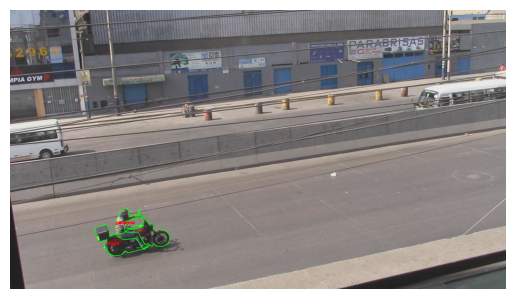

motos_detectadas\dataset\train\images\moto_1730058485.jpg


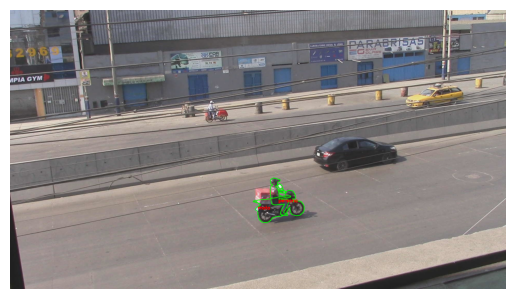

motos_detectadas\dataset\train\images\moto_1730058662.jpg


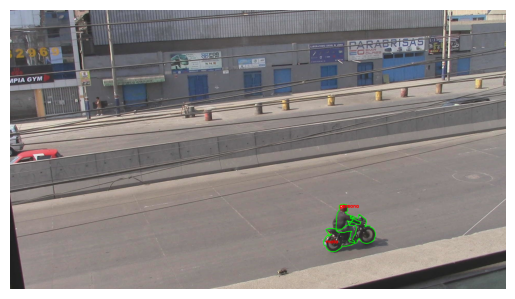

motos_detectadas\dataset\train\images\moto_1730058794.jpg


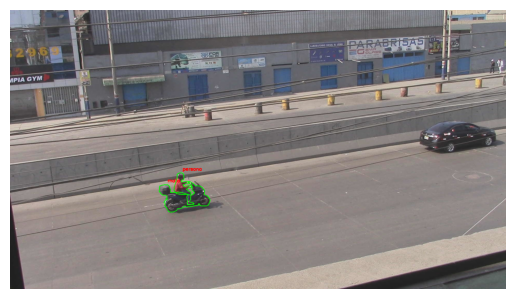

motos_detectadas\dataset\train\images\moto_1730058795.jpg


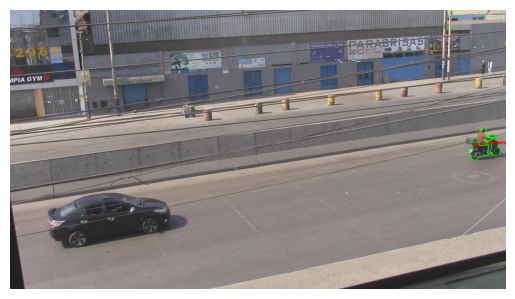

In [47]:
import cv2
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

def plot_labels(image_path, label_path, class_names, img_size=(1920, 1080)):
    # Leer la imagen
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Leer el archivo de etiquetas (formato YOLO)
    with open(label_path, 'r') as file:
        labels = file.readlines()

    # Dibujar cada etiqueta
    for label in labels:
        parts = label.strip().split()
        cls, segmentation = int(parts[0]), list(map(float, parts[1:]))
        # Las coordenadas de la máscara están en pares (x, y)
        points = [(segmentation[i] * img_size[0], segmentation[i+1] * img_size[1]) 
                  for i in range(0, len(segmentation), 2)]
        points = np.array(points, np.int32).reshape((-1, 1, 2))
        cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.putText(image, class_names[cls], (int(points[0][0][0]), int(points[0][0][1] - 10)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Mostrar la imagen
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Configuración
image_folder = os.path.join(train_dir, 'images')  
label_folder = os.path.join(train_dir, 'labels') 
class_names = ["moto", "persona"]   

# Visualizar imágenes aleatorias
image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))
for image_path in image_paths[:5]:  # Visualizar las primeras 5 imágenes
    label_path = os.path.join(label_folder, os.path.basename(image_path).replace(".jpg", ".txt"))
    if os.path.exists(label_path):
        print(image_path)
        plot_labels(image_path, label_path, class_names)
    else:
        print(f"No se encontró la etiqueta para {image_path}")
